In [1]:
import duckdb
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.feature_selection import mutual_info_regression


# run utils.db_setup to set up duckdb database
conn = duckdb.connect('f1.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

# graphs too large for interactivity
pio.renderers.default = 'svg'

## Schema

![](f1_schema.png)

## Tasks

### `rel-f1-position`

Task is to predict the average finishing position of each driver all races in the next 2 months.

Regression

Metric: MAE

In [9]:
%%sql train_df <<
from position_train

In [10]:
train_df.head()

,date,driverId,position
0,2004-07-05,31,10.750000
1,2004-05-06,1,11.833333
2,2004-03-07,3,5.666667
3,2004-01-07,31,11.000000
4,2004-01-07,22,4.000000


In [15]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.driverId.nunique():,} drivers.')
print()
print('Temporal dist of samples:')
months = train_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / train_df.driverId.nunique()
)
print()
print('Label Distribution:')
mean = train_df.position.mean()
std = train_df.position.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.position == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.position.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

7,453 samples over 771 drivers.

Temporal dist of samples:
date
1950-06    0.002549
1950-08    0.003623
1951-04    0.007380
1951-06    0.005233
1951-08    0.002952
             ...   
2004-01    0.002683
2004-03    0.002683
2004-05    0.002952
2004-07    0.002952
2004-09    0.003086
Name: proportion, Length: 254, dtype: float64

Temporal dist of drivers (first appearance):
date
1950-06    0.007782
1950-08    0.011673
1951-04    0.022049
1951-06    0.015564
1951-08    0.007782
             ...   
2003-09    0.003891
2004-01    0.001297
2004-03    0.002594
2004-05    0.002594
2004-09    0.005188
Name: driverId, Length: 208, dtype: float64

Label Distribution:
Mean (std): 13.9 ± 7.0
Prop zeros: 0.0%
Quantiles: 
0.0     1.000000
0.1     5.000000
0.2     8.000000
0.3    10.000000
0.4    11.666667
0.5    13.333333
0.6    15.000000
0.7    17.000000
0.8    19.500000
0.9    23.000000
1.0    39.000000
Name: position, dtype: float64


In [16]:
%%sql val_df <<
from position_val

In [18]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.driverId.nunique():,} drivers.')
print()
print('Temporal dist of samples:')
months = val_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / val_df.driverId.nunique()
)
print()
print(f'Drivers in val seen in train: {len(set(val_df.driverId) & set(train_df.driverId)):,}')
print()
print('Label Distribution:')
mean = val_df.position.mean()
std = val_df.position.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.position == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.position.quantile(np.arange(0, 1.1, 0.1))}')

VAL

499 samples over 47 drivers.

Temporal dist of samples:
date
2005-03    0.048096
2005-05    0.044088
2005-06    0.042084
2005-08    0.040080
2006-02    0.044088
2006-04    0.044088
2006-06    0.050100
2006-08    0.046092
2007-02    0.044088
2007-04    0.046092
2007-06    0.050100
2007-08    0.044088
2007-10    0.044088
2008-02    0.044088
2008-04    0.044088
2008-06    0.040080
2008-08    0.040080
2008-10    0.040080
2009-02    0.040080
2009-04    0.040080
2009-06    0.042084
2009-08    0.042084
2009-10    0.040080
Name: proportion, dtype: float64

Temporal dist of drivers (first appearance):
date
2005-03    0.085106
2005-05    0.106383
2005-06    0.042553
2005-08    0.042553
2006-02    0.085106
2006-04    0.021277
2006-06    0.085106
2006-08    0.021277
2007-02    0.042553
2007-04    0.021277
2007-06    0.085106
2007-08    0.021277
2008-06    0.021277
2008-10    0.042553
2009-04    0.021277
2009-06    0.127660
2009-08    0.063830
2009-10    0.063830
Name: driverId, dtype: float64

### `rel-f1-dnf`

Task is to predict whether a driver will DNF (not finish) a race in the next 1 month.

Binary classification

Metric: ROCAUC

In [19]:
%%sql train_df <<
from dnf_train

In [22]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.driverId.nunique():,} drivers.')
print()
print('Label Distribution:')
print(train_df.did_not_finish.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = train_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / train_df.driverId.nunique()
)

TRAIN

11,411 samples over 780 drivers.

Label Distribution:
did_not_finish
0    0.880379
1    0.119621
Name: proportion, dtype: float64

Temporal dist of samples:
date
1950-05    0.005521
1950-06    0.001665
1950-08    0.002366
1951-05    0.004820
1951-06    0.003067
             ...   
2004-06    0.001928
2004-07    0.001840
2004-08    0.001753
2004-09    0.002016
2004-10    0.001840
Name: proportion, Length: 413, dtype: float64

Temporal dist of drivers (first appearance):
date
1950-05    0.030769
1950-06    0.008974
1950-08    0.010256
1951-05    0.014103
1951-06    0.016667
             ...   
2003-10    0.001282
2004-03    0.001282
2004-04    0.001282
2004-05    0.001282
2004-10    0.001282
Name: driverId, Length: 276, dtype: float64


In [23]:
%%sql val_df <<
from dnf_val

In [24]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.driverId.nunique():,} drivers.')
print()
print('Label Distribution:')
print(val_df.did_not_finish.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = val_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print(f'Drivers in val seen in train: {len(set(val_df.driverId) & set(train_df.driverId)):,}')
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / val_df.driverId.nunique()
)

VAL

566 samples over 42 drivers.

Label Distribution:
did_not_finish
0    0.779152
1    0.220848
Name: proportion, dtype: float64

Temporal dist of samples:
date
2005-03    0.037102
2005-04    0.038869
2005-05    0.072438
2005-06    0.037102
2005-07    0.035336
2005-08    0.035336
2005-09    0.035336
2006-02    0.038869
2006-03    0.038869
2006-04    0.038869
2006-05    0.038869
2006-06    0.040636
2006-07    0.040636
2006-08    0.038869
2006-09    0.038869
2007-02    0.038869
2007-03    0.038869
2007-04    0.038869
2007-05    0.040636
2007-06    0.038869
2007-07    0.042403
2007-08    0.038869
2007-09    0.038869
2007-10    0.038869
2008-03    0.038869
Name: proportion, dtype: float64

Drivers in val seen in train: 22

Temporal dist of drivers (first appearance):
date
2005-03    0.023810
2005-04    0.238095
2005-05    0.071429
2005-06    0.023810
2005-07    0.023810
2005-08    0.023810
2005-09    0.023810
2006-02    0.071429
2006-05    0.095238
2006-07    0.023810
2006-08    0.071429

### `rel-f1-qualifying`

Task is to predict if each driver will qualify in the top-3 for a race within the next 1 month.

Binary classification

Metric: ROCAUC

In [25]:
%%sql train_df <<
from qualifying_train

In [26]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.driverId.nunique():,} drivers.')
print()
print('Label Distribution:')
print(train_df.qualifying.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = train_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / train_df.driverId.nunique()
)

TRAIN

1,353 samples over 92 drivers.

Label Distribution:
qualifying
0    0.829268
1    0.170732
Name: proportion, dtype: float64

Temporal dist of samples:
date
1994-02    0.019217
1994-03    0.019217
1994-04    0.023651
1994-05    0.019217
1994-06    0.019956
1994-07    0.020695
1994-08    0.019956
1994-09    0.019217
1994-10    0.020695
1995-02    0.019217
1995-03    0.019217
1995-04    0.019956
1995-05    0.019217
1995-06    0.018477
1995-07    0.019217
1995-08    0.017738
1995-09    0.021434
1995-10    0.018477
1996-02    0.014782
1996-03    0.016260
1996-04    0.016260
1996-05    0.014782
1997-02    0.016260
1997-03    0.016260
1997-04    0.016260
1997-05    0.016260
1997-06    0.017738
1997-07    0.016260
1998-02    0.016260
1998-03    0.016260
1998-04    0.016260
1998-07    0.016260
1998-08    0.016260
1999-03    0.016260
1999-04    0.016999
2000-02    0.016260
2000-03    0.016260
2000-09    0.016260
2001-09    0.016260
2002-02    0.016260
2002-09    0.014782
2003-02    0.0147

In [27]:
%%sql val_df <<
from qualifying_val

In [28]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.driverId.nunique():,} drivers.')
print()
print('Label Distribution:')
print(val_df.qualifying.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = val_df.date.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print(f'Drivers in val seen in train: {len(set(val_df.driverId) & set(train_df.driverId)):,}')
print()
print('Temporal dist of drivers (first appearance):')
print(
    # date is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='driverId', keep='last')
    .groupby(months).driverId.nunique() / val_df.driverId.nunique()
)

VAL

588 samples over 42 drivers.

Label Distribution:
qualifying
0    0.797619
1    0.202381
Name: proportion, dtype: float64

Temporal dist of samples:
date
2005-03    0.035714
2005-04    0.037415
2005-05    0.069728
2005-06    0.035714
2005-07    0.034014
2005-08    0.034014
2005-09    0.034014
2006-02    0.037415
2006-03    0.037415
2006-04    0.037415
2006-05    0.037415
2006-06    0.039116
2006-07    0.039116
2006-08    0.037415
2006-09    0.037415
2007-02    0.037415
2007-03    0.037415
2007-04    0.037415
2007-05    0.039116
2007-06    0.037415
2007-07    0.040816
2007-08    0.037415
2007-09    0.037415
2007-10    0.037415
2008-02    0.037415
2008-03    0.037415
Name: proportion, dtype: float64

Drivers in val seen in train: 21

Temporal dist of drivers (first appearance):
date
2005-03    0.071429
2005-05    0.119048
2005-06    0.047619
2005-07    0.095238
2005-08    0.071429
2006-02    0.142857
2006-04    0.023810
2006-05    0.023810
2006-06    0.023810
2006-08    0.023810
200

## Circuits

In [8]:
%%sql circuits <<
from circuits

In [9]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng
0,0,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800
1,1,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800
2,2,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060
3,3,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111
4,4,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500


In [10]:
circuits.location.value_counts()

location
Barcelona       2
California      2
Melbourne       1
Reims           1
Le Mans         1
               ..
Buenos Aires    1
Abu Dhabi       1
Las Vegas       1
Suzuka          1
Miami           1
Name: count, Length: 75, dtype: int64

## Races

In [31]:
%%sql
from races

,raceId,year,round,circuitId,name,date,time
0,0,1950,1,8,British Grand Prix,1950-05-13 00:00:00,00:00:00
1,1,1950,2,5,Monaco Grand Prix,1950-05-21 00:00:00,00:00:00
2,2,1950,3,18,Indianapolis 500,1950-05-30 00:00:00,00:00:00
3,3,1950,4,65,Swiss Grand Prix,1950-06-04 00:00:00,00:00:00
4,4,1950,5,12,Belgian Grand Prix,1950-06-18 00:00:00,00:00:00
...,...,...,...,...,...,...,...
815,815,2009,13,13,Italian Grand Prix,2009-09-13 12:00:00,12:00:00
816,816,2009,14,14,Singapore Grand Prix,2009-09-27 12:00:00,12:00:00
817,817,2009,15,21,Japanese Grand Prix,2009-10-04 05:00:00,05:00:00
818,818,2009,16,17,Brazilian Grand Prix,2009-10-18 16:00:00,16:00:00


In [37]:
%%sql label_periods <<
-- how many races in 1 month label periods
with timestamps as (
    select distinct date
    from position_train
)
select
    timestamps.date,
    count(*) as num_races,
    min(round) as starting_round,
    max(round) as ending_round,
    list(name order by races.date asc) as race_list
from timestamps
left join races
    on timestamps.date <= races.date
    and timestamps.date + interval '1 month' > races.date
group by timestamps.date
order by timestamps.date desc

In [38]:
label_periods.sample(10)

,date,num_races,starting_round,ending_round,race_list
185,1967-05-21,2,3.0,4.0,"[Dutch Grand Prix, Belgian Grand Prix]"
120,1980-01-13,2,1.0,2.0,"[Argentine Grand Prix, Brazilian Grand Prix]"
60,1992-09-06,2,13.0,14.0,"[Italian Grand Prix, Portuguese Grand Prix]"
23,2000-03-28,2,3.0,4.0,"[San Marino Grand Prix, British Grand Prix]"
204,1963-06-11,2,3.0,4.0,"[Dutch Grand Prix, French Grand Prix]"
7,2003-05-12,2,6.0,7.0,"[Austrian Grand Prix, Monaco Grand Prix]"
146,1975-06-08,3,7.0,9.0,"[Swedish Grand Prix, Dutch Grand Prix, French ..."
26,1999-08-01,3,10.0,12.0,"[German Grand Prix, Hungarian Grand Prix, Belg..."
216,1960-04-27,1,NaN,NaN,[None]
22,2000-05-27,2,7.0,8.0,"[Monaco Grand Prix, Canadian Grand Prix]"


In [39]:
label_periods.num_races.describe()

count    254.000000
mean       1.653543
std        0.675698
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: num_races, dtype: float64

In [40]:
label_periods.starting_round.describe()

count    204.000000
mean       6.995098
std        4.415041
min        1.000000
25%        3.000000
50%        7.000000
75%       10.000000
max       16.000000
Name: starting_round, dtype: float64

In [43]:
label_periods.starting_round.quantile(np.arange(0, 1.1, 0.1))

0.0     1.0
0.1     1.0
0.2     3.0
0.3     3.9
0.4     5.0
0.5     7.0
0.6     8.0
0.7     9.0
0.8    11.0
0.9    14.0
1.0    16.0
Name: starting_round, dtype: float64

In [46]:
all_races = sum(label_periods.race_list.apply(list).tolist(), [])

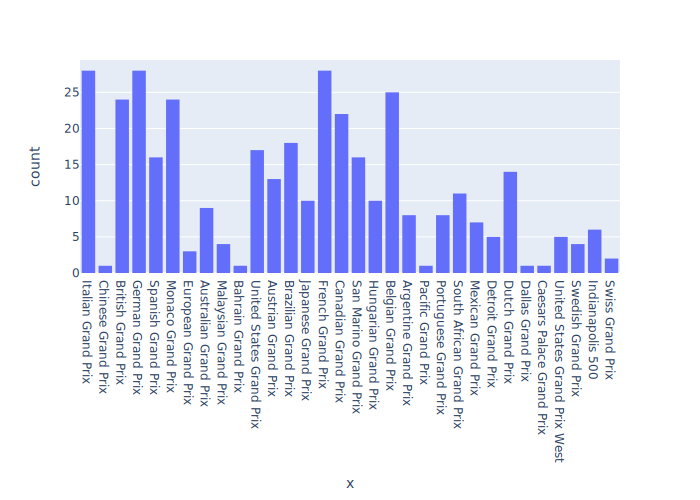

In [50]:
px.histogram(x=all_races)

## Constructors

In [30]:
%%sql
from constructors

,constructorId,constructorRef,name,nationality
0,0,mclaren,McLaren,British
1,1,bmw_sauber,BMW Sauber,German
2,2,williams,Williams,British
3,3,renault,Renault,French
4,4,toro_rosso,Toro Rosso,Italian
...,...,...,...,...
206,206,manor,Manor Marussia,British
207,207,haas,Haas F1 Team,American
208,208,racing_point,Racing Point,British
209,209,alphatauri,AlphaTauri,Italian


## Drivers

In [5]:
%%sql drivers <<
from drivers

In [6]:
drivers.head()

,driverId,driverRef,code,forename,surname,dob,nationality
0,0,hamilton,HAM,Lewis,Hamilton,1985-01-07,British
1,1,heidfeld,HEI,Nick,Heidfeld,1977-05-10,German
2,2,rosberg,ROS,Nico,Rosberg,1985-06-27,German
3,3,alonso,ALO,Fernando,Alonso,1981-07-29,Spanish
4,4,kovalainen,KOV,Heikki,Kovalainen,1981-10-19,Finnish


In [53]:
drivers.nationality.value_counts()

nationality
British              165
American             158
Italian               99
French                73
German                50
Brazilian             32
Argentine             24
Belgian               23
Swiss                 23
South African         23
Japanese              20
Dutch                 18
Australian            18
Austrian              15
Spanish               15
Canadian              14
Swedish               10
Finnish                9
New Zealander          9
Mexican                6
Irish                  5
Danish                 5
Monegasque             4
Russian                4
Uruguayan              4
Portuguese             4
Rhodesian              4
East German            3
Venezuelan             3
Colombian              3
Indian                 2
Thai                   2
Indonesian             1
Argentine-Italian      1
Czech                  1
American-Italian       1
Liechtensteiner        1
Chilean                1
Malaysian              1
Hungarian    

## Constructor Standings

In [55]:
%%sql
from constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,wins,date
0,0,64,103,3.0,3,0,1958-01-19 00:00:00
1,1,64,5,6.0,2,0,1958-01-19 00:00:00
2,2,64,85,8.0,1,1,1958-01-19 00:00:00
3,3,65,85,16.0,1,2,1958-05-18 00:00:00
4,4,65,31,0.0,5,0,1958-05-18 00:00:00
...,...,...,...,...,...,...,...
10165,10165,819,3,26.0,8,0,2009-11-01 11:00:00
10166,10166,819,1,36.0,6,0,2009-11-01 11:00:00
10167,10167,819,2,34.5,7,0,2009-11-01 11:00:00
10168,10168,819,4,8.0,10,0,2009-11-01 11:00:00


In [58]:
%%sql
from constructor_standings
where constructorId = 0
order by raceId desc

,constructorStandingsId,raceId,constructorId,points,position,wins,date
0,10163,819,0,71.0,3,2,2009-11-01 11:00:00
1,10153,818,0,71.0,3,2,2009-10-18 16:00:00
2,10147,817,0,65.0,4,2,2009-10-04 05:00:00
3,10136,816,0,59.0,4,2,2009-09-27 12:00:00
4,10120,815,0,47.0,4,1,2009-09-13 12:00:00
...,...,...,...,...,...,...,...
619,1383,172,0,0.0,14,0,1968-11-03 00:00:00
620,1364,171,0,0.0,14,0,1968-10-06 00:00:00
621,1353,170,0,0.0,14,0,1968-09-22 00:00:00
622,1337,169,0,0.0,14,0,1968-09-08 00:00:00


## Constructor Results

In [59]:
%%sql
from constructor_results

,constructorResultsId,raceId,constructorId,points,status,date
0,0,48,103,13.0,\N,1956-01-22 00:00:00
1,1,48,5,12.0,\N,1956-01-22 00:00:00
2,2,54,126,0.0,\N,1956-08-05 00:00:00
3,3,54,103,15.0,\N,1956-08-05 00:00:00
4,4,54,5,9.0,\N,1956-08-05 00:00:00
...,...,...,...,...,...,...
9403,9403,819,5,0.0,\N,2009-11-01 11:00:00
9404,9404,819,0,0.0,\N,2009-11-01 11:00:00
9405,9405,819,2,0.0,\N,2009-11-01 11:00:00
9406,9406,819,4,1.0,\N,2009-11-01 11:00:00


## Standings

In [2]:
%%sql
from standings

,driverStandingsId,raceId,driverId,points,position,wins,date
0,0,0,789,0.0,20,0,1950-05-13 00:00:00
1,1,0,640,0.0,18,0,1950-05-13 00:00:00
2,2,0,589,0.0,19,0,1950-05-13 00:00:00
3,3,0,669,0.0,15,0,1950-05-13 00:00:00
4,4,0,661,0.0,22,0,1950-05-13 00:00:00
...,...,...,...,...,...,...,...
28110,28110,819,7,48.0,6,1,2009-11-01 11:00:00
28111,28111,819,68,0.0,25,0,2009-11-01 11:00:00
28112,28112,819,11,0.0,21,0,2009-11-01 11:00:00
28113,28113,819,6,2.0,19,0,2009-11-01 11:00:00


## Results

In [61]:
%%sql
from results

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,milliseconds,fastestLap,rank,statusId,date
0,0,0,660,152,18.0,21,11.0,11,0.0,64,NaN,NaN,NaN,16,1950-05-13 00:00:00
1,1,0,790,149,8.0,12,NaN,21,0.0,2,NaN,NaN,NaN,126,1950-05-13 00:00:00
2,2,0,579,49,1.0,3,NaN,12,0.0,62,NaN,NaN,NaN,44,1950-05-13 00:00:00
3,3,0,661,149,9.0,10,NaN,20,0.0,5,NaN,NaN,NaN,6,1950-05-13 00:00:00
4,4,0,789,152,17.0,7,NaN,19,0.0,8,NaN,NaN,NaN,51,1950-05-13 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20318,20318,819,1,1,6.0,8,5.0,5,4.0,55,5669667.0,54.0,7.0,1,2009-11-01 11:00:00
20319,20319,819,21,22,23.0,4,4.0,4,5.0,55,5666149.0,54.0,4.0,1,2009-11-01 11:00:00
20320,20320,819,17,22,22.0,5,3.0,3,6.0,55,5661881.0,49.0,6.0,1,2009-11-01 11:00:00
20321,20321,819,16,8,14.0,3,2.0,2,8.0,55,5661271.0,14.0,5.0,1,2009-11-01 11:00:00


In [ ]:
%%sql
-- duplicates!
select
    raceId,
    driverId,
    count(*) as count
from results
group by raceId, driverId
having count > 1

In [67]:
%%sql dnfs_over_time <<
select
    strftime('%Y-%m', date) as month,
    avg((statusId != 1)::int) as dnfs
from results
group by month


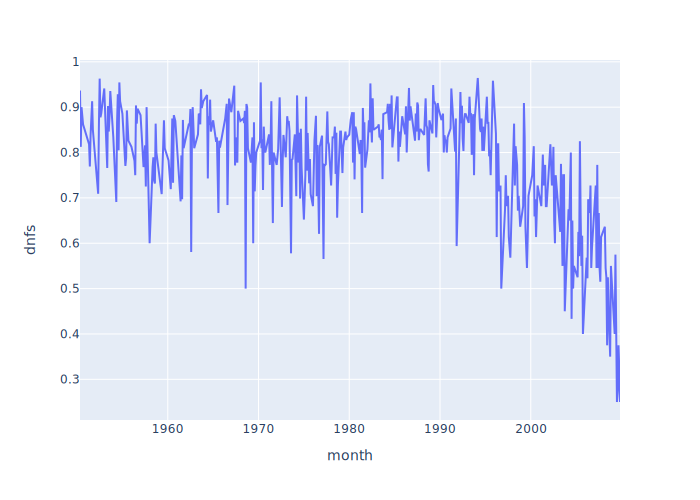

In [68]:
px.line(dnfs_over_time.sort_values(by='month'), x='month', y='dnfs')

In [83]:
%%sql dnfs_over_time <<
select
    raceId,
    any_value(date_part('year', date)) as year,
    avg((statusId != 1)::int) as dnfs
from results
group by raceId

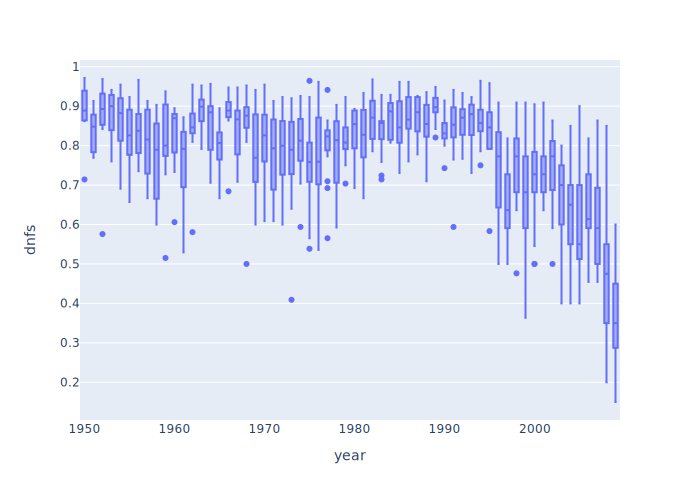

In [85]:
px.box(dnfs_over_time, x='year', y='dnfs')

In [ ]:
%%sql dnfs_over_time <<
select
    raceId,
    any_value(date_part('year', date)) as year,
    avg((statusId = 1)::int) as dnfs
from results
group by raceId

In [95]:
%%sql accidents <<
select
    raceId,
    any_value(date_part('year', date)) as year,
    sum((statusId in (3, 4))::int) as accident_or_collision
from results
group by raceId

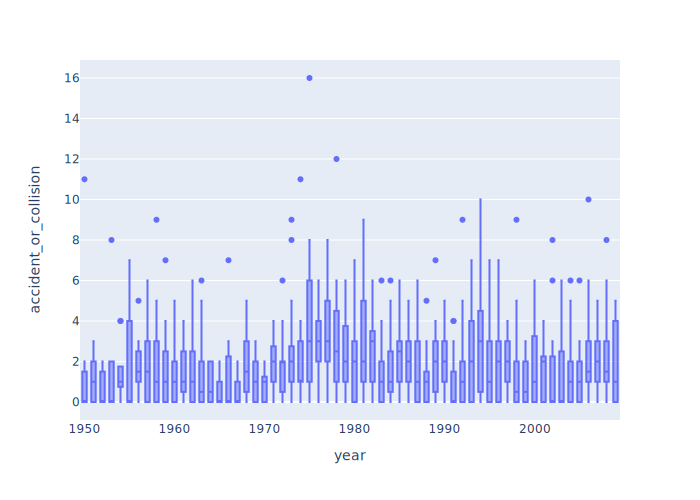

In [96]:
px.box(accidents, x='year', y='accident_or_collision')

In [94]:
%%sql
select
    statusId,
    count(*) as count,
    count(*) / sum(count(*)) over () as prop
from results
group by statusId
order by prop desc

,statusId,count,prop
0,1,4369,0.214978
1,11,2508,0.123407
2,5,1921,0.094523
3,12,1279,0.062934
4,81,1021,0.050239
...,...,...,...
120,120,1,0.000049
121,122,1,0.000049
122,123,1,0.000049
123,125,1,0.000049


## Qualifying

In [3]:
%%sql
from qualifying

,qualifyId,raceId,driverId,constructorId,number,position,date
0,0,548,43,26,26,19,1994-03-26 00:00:00
1,1,548,100,30,31,26,1994-03-26 00:00:00
2,2,548,91,29,34,25,1994-03-26 00:00:00
3,3,548,82,31,11,24,1994-03-26 00:00:00
4,4,548,105,32,19,23,1994-03-26 00:00:00
...,...,...,...,...,...,...,...
4077,4077,819,21,22,23,4,2009-10-31 11:00:00
4078,4078,819,16,8,14,3,2009-10-31 11:00:00
4079,4079,819,19,8,15,2,2009-10-31 11:00:00
4080,4080,819,0,0,1,1,2009-10-31 11:00:00


In [11]:
conn.close()